# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. 
The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [1]:
# Imports here
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models


from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import json

import PIL
from PIL import Image
import os

#import workspace_utils

## Load the data

The dataset is split into three parts, training, validation, and testing. For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define a transform to normalize the data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = torchvision.datasets.ImageFolder(train_dir,transform=train_transforms)

# Download and load the training data

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# TODO: Load the datasets with ImageFolder
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
validloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [6]:
len(test_data)

819

In [7]:
test_data[1][0].shape

torch.Size([3, 224, 224])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [10]:
def find_class_to_idx(dir):
    indices = os.listdir(dir)
    indices.sort()
    class_to_idx = {i:indices[i] for i in range(len(indices))}
    return class_to_idx

class_to_index=find_class_to_idx(train_dir)

In [11]:
class_to_index

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

In [12]:
class_to_label={}
for clas in class_to_index.keys():
    class_to_label[clas]=cat_to_name[class_to_index[clas]]

In [13]:
class_to_label

{0: 'pink primrose',
 1: 'globe thistle',
 2: 'blanket flower',
 3: 'trumpet creeper',
 4: 'blackberry lily',
 5: 'snapdragon',
 6: "colt's foot",
 7: 'king protea',
 8: 'spear thistle',
 9: 'yellow iris',
 10: 'globe-flower',
 11: 'purple coneflower',
 12: 'peruvian lily',
 13: 'balloon flower',
 14: 'hard-leaved pocket orchid',
 15: 'giant white arum lily',
 16: 'fire lily',
 17: 'pincushion flower',
 18: 'fritillary',
 19: 'red ginger',
 20: 'grape hyacinth',
 21: 'corn poppy',
 22: 'prince of wales feathers',
 23: 'stemless gentian',
 24: 'artichoke',
 25: 'canterbury bells',
 26: 'sweet william',
 27: 'carnation',
 28: 'garden phlox',
 29: 'love in the mist',
 30: 'mexican aster',
 31: 'alpine sea holly',
 32: 'ruby-lipped cattleya',
 33: 'cape flower',
 34: 'great masterwort',
 35: 'siam tulip',
 36: 'sweet pea',
 37: 'lenten rose',
 38: 'barbeton daisy',
 39: 'daffodil',
 40: 'sword lily',
 41: 'poinsettia',
 42: 'bolero deep blue',
 43: 'wallflower',
 44: 'marigold',
 45: 'butt

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we will one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

When training we need to  update only the weights of the feed-forward network

In [14]:
# Build and train your network
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [16]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
                          ('drop1',nn.Dropout(p=.30)),  
                          ('fc2', nn.Linear(4096, 1000)),
                          ('relu2', nn.ReLU()), 
                          ('drop2',nn.Dropout(p=.30)), 
                          ('fc3', nn.Linear(1000, 102)),  
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [17]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0008)

device='cuda'
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [18]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    valid_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 5.157.. Validation loss: 4.542.. Validation accuracy: 0.087
Epoch 1/10.. Train loss: 4.509.. Validation loss: 4.145.. Validation accuracy: 0.118
Epoch 1/10.. Train loss: 4.229.. Validation loss: 3.815.. Validation accuracy: 0.180
Epoch 1/10.. Train loss: 4.048.. Validation loss: 3.522.. Validation accuracy: 0.240
Epoch 1/10.. Train loss: 3.650.. Validation loss: 3.249.. Validation accuracy: 0.260
Epoch 1/10.. Train loss: 3.523.. Validation loss: 2.894.. Validation accuracy: 0.331
Epoch 1/10.. Train loss: 3.252.. Validation loss: 2.562.. Validation accuracy: 0.403
Epoch 1/10.. Train loss: 3.046.. Validation loss: 2.367.. Validation accuracy: 0.412
Epoch 1/10.. Train loss: 2.890.. Validation loss: 2.096.. Validation accuracy: 0.480
Epoch 1/10.. Train loss: 2.704.. Validation loss: 1.943.. Validation accuracy: 0.504
Epoch 1/10.. Train loss: 2.658.. Validation loss: 1.745.. Validation accuracy: 0.564
Epoch 1/10.. Train loss: 2.223.. Validation loss: 1.573.. Validat

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images

In [19]:
test_loss = 0 
test_accuracy = 0 
model.eval() 
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device) 
        logps = model.forward(inputs) 
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
        # Calculate accuracy 
        ps = torch.exp(logps) 
        top_p, top_class = ps.topk(1, dim=1) 
        equals = top_class == labels.view(*top_class.shape) 
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Test loss: {test_loss/len(testloader):.3f}.. " 
          f"Test accuracy: {test_accuracy/len(testloader):.3f}")


Test loss: 0.398.. Test accuracy: 0.894


In [20]:
model.class_to_index=class_to_index
model.class_to_label=class_to_label

## Save the checkpoint

Now that your network is trained, save the model so that we can load it later for making predictions. We will save other things such as the mapping of classes to indices which you get from one of the image datasets. You can attach this to the model as an attribute which makes inference easier later on.


In [21]:
# Save the checkpoint 
checkpoint = {'architecture': 'vgg16', 
               'model_state_dict': model.state_dict(), 
               'model_class_to_index': model.class_to_index, 
               'model_class_to_label': model.class_to_label, 
               'model_classifier': model.classifier}
torch.save(checkpoint, 'checkpoint4.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [23]:
# Write a function that loads a checkpoint and rebuilds the model

def load_build(checkpoint):
    checkpoint_load=torch.load(checkpoint)
    model=models.__dict__[checkpoint_load['architecture']](pretrained=True)
    model.classifier=checkpoint_load['model_classifier']
    model.load_state_dict(checkpoint_load['model_state_dict'])
    model.class_to_index=checkpoint_load['model_class_to_index']
    model.class_to_label=checkpoint_load['model_class_to_label']
    
    return model

model=load_build("checkpoint4.pth")

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. The function will return the top $K$ most likely classes along with the probabilities. 

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 


In [24]:
# Import an images
test_image_1="./flowers/test/1/image_06760.jpg"
test_image_2="./flowers/test/55/image_04740.jpg"

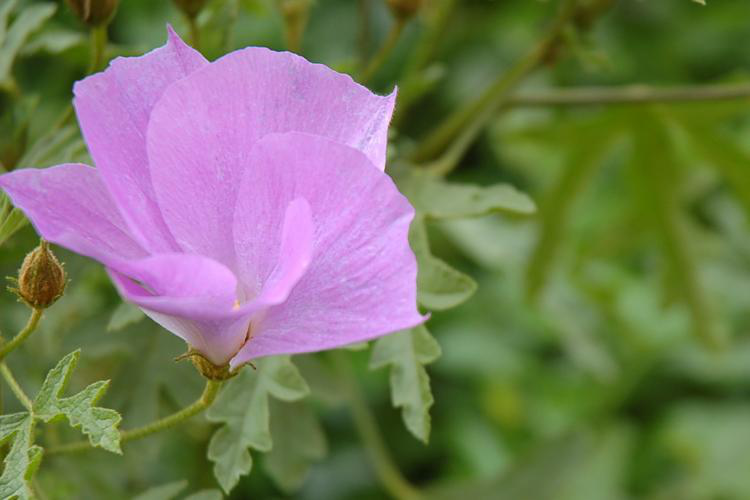

In [25]:
Image.open(test_image_2)

In [26]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    

    
    im = Image.open(image)
    ratio=min(im.size)/256
    width=(im.size[0]/ratio)
    height=(im.size[1]/ratio)
    im.thumbnail((width,height),Image.ANTIALIAS)
    left=(im.size[0]-224)/2
    right=left+224
    top=(im.size[1]-224)/2
    bottom=top+224
    im2=im.crop((left, top, right, bottom))
    np_image=np.array(im2)

    np_image_std=np.copy(np_image)
    dim0=((np_image_std[:,:,0]-np.mean(np_image_std[:,:,0]))/np.std(np_image_std[:,:,0])*(.229))+.485
    dim1=((np_image_std[:,:,1]-np.mean(np_image_std[:,:,1]))/np.std(np_image_std[:,:,1])*(.224))+.456
    dim2=((np_image_std[:,:,2]-np.mean(np_image_std[:,:,2]))/np.std(np_image_std[:,:,2])*(.225))+.406
    
    np_image_norm=np.stack((dim0,dim1,dim2),axis=-1)
    np_image_norm_tp=np.transpose(np_image_norm,(2,0,1))
    
    return np_image_norm_tp
    
    
    

In [27]:
image_processed=process_image(test_image_2)

In [28]:
image_processed.shape

(3, 224, 224)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [29]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

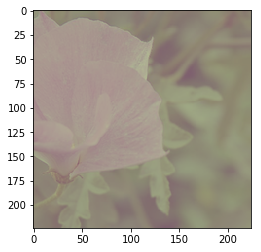

In [30]:
imshow(image_processed,ax=None,title=None)

## Class Prediction

In [31]:
test_image_3="./flowers/test/8/image_03359.jpg"
test_image_4="./flowers/test/96/image_07646.jpg"
test_image_5="./flowers/test/36/image_04344.jpg"
test_image_6="./flowers/test/20/image_04938.jpg"

In [32]:
np_image=process_image(test_image_5)

image_tensor=torch.from_numpy(np_image)
image_tensor=image_tensor.view((1,3,224,224))
image_tensor=image_tensor.type(torch.float32)

model.to('cuda')
inputs=image_tensor.to('cuda')
model.eval()
with torch.no_grad():
    logps=model.forward(inputs)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(5, dim=1)
    
top_p=top_p.view((5,)).cpu().tolist()
top_class=top_class.view((5,)).cpu().tolist()

top_class_index=[class_to_index[i] for i in top_class]
top_class_name=[class_to_label[i] for i in top_class]
top_df=pd.DataFrame({'prob':top_p,'index':top_class_index,'label':top_class_name},columns=['label','index','prob'])
top_df

,label,index,prob
0,ruby-lipped cattleya,36,0.999891
1,cyclamen,88,0.000041
2,camellia,96,0.000030
3,sweet pea,4,0.000016
4,sword lily,43,0.000007


In [33]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    np_image=process_image(image_path)

    image_tensor=torch.from_numpy(np_image)
    image_tensor=image_tensor.view((1,3,224,224))
    image_tensor=image_tensor.type(torch.float32)

    model.to('cuda')
    inputs=image_tensor.to('cuda')
    model.eval()
    with torch.no_grad():
        logps=model.forward(inputs)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(topk, dim=1)

    top_p=top_p.view((topk,)).cpu().tolist()
    top_class=top_class.view((topk,)).cpu().tolist()

    top_class_index=[class_to_index[i] for i in top_class]
    top_class_name=[class_to_label[i] for i in top_class]
    top_df=pd.DataFrame({'prob':top_p,'index':top_class_index,'label':top_class_name},columns=['label','index','prob'])
    return top_df

In [34]:
predict(test_image_5,model,topk=6)

,label,index,prob
0,ruby-lipped cattleya,36,0.999891
1,cyclamen,88,0.000041
2,camellia,96,0.000030
3,sweet pea,4,0.000016
4,sword lily,43,0.000007
5,hippeastrum,91,0.000003


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense

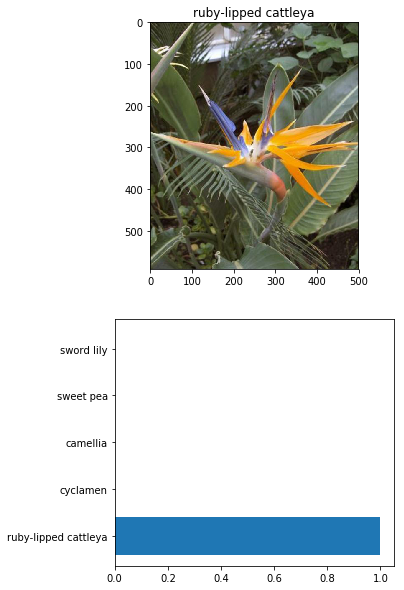

In [35]:
#Display an image along with the top 5 classes

test_image_5="./flowers/test/36/image_04344.jpg"
image_folder='36'
image_name=cat_to_name[image_folder]

top_df=predict(test_image_5,model,topk=5)

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(5,10))
im=mpimg.imread(test_image_3)
ax1.imshow(im)
ax1.set_title(image_name)

df=top_df[['prob','label']]
ax2.barh(y=range(len(top_df['label'])),width=top_df['prob'],tick_label=top_df['label'])
plt.show()